In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/timeseriesmodels/TimeSerieEnsemble/timeserieensemble.ipynb
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/2/variables.index
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/2/fingerprint.pb
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/2/saved_model.pb
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/2/variables.data-00000-of-00001
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/2/keras_metadata.pb
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/5/variables.index
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/5/fingerprint.pb
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/5/saved_model.pb
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/5/variables.data-00000-of-00001
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/5/keras_metadata.pb
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/0/variables.index
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/0/fingerprint.pb
/kaggle/input/timeseriesmodels/TimeSerieEnsemble/0/saved_model.pb
/kaggle/input/timeseriesmodels

In [10]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
np.random.seed(seed)
import pandas as pd
import logging
import seaborn as sns
import random
random.seed(seed)
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

2.13.0


In [12]:
# Assuming the dataset is in the /kaggle/input/ directory
categories_data_path = '/kaggle/input/timeseriesdataset/categories.npy'
training_data_path = '/kaggle/input/timeseriesdataset/training_data.npy'
valid_periods_data_path = '/kaggle/input/timeseriesdataset/valid_periods.npy'

# Load the data
categories_data = np.load(categories_data_path,allow_pickle=True)
training_data = np.load(training_data_path,allow_pickle=True)
valid_periods_data = np.load(valid_periods_data_path,allow_pickle=True)

# Convert NumPy arrays to pandas DataFrames
categories_df = pd.DataFrame(categories_data)

training_df = pd.DataFrame(training_data)
training_df = training_df.astype('float32')

valid_periods_df = pd.DataFrame(valid_periods_data)

# Display the DataFrames
print("Categories DataFrame:")
print(categories_df.info())  # Display the first few rows
print("\nTraining DataFrame:")
print(training_df.info())    # Display the first few rows
print("\nValid Periods DataFrame:")
print(valid_periods_df.info())  # Display the first few rows


unique_values_count = categories_df.value_counts()
unique_values_count

Categories DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       48000 non-null  object
dtypes: object(1)
memory usage: 375.1+ KB
None

Training DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.3 MB
None

Valid Periods DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       48000 non-null  int64
 1   1       48000 non-null  int64
dtypes: int64(2)
memory usage: 750.1 KB
None


B    10987
E    10975
C    10017
D    10016
A     5728
F      277
Name: count, dtype: int64

# Data Inspection

In [13]:
# Calculate the differences and add a new column 'difference'
valid_periods_df['difference'] = valid_periods_df.iloc[:, 1] - valid_periods_df.iloc[:, 0]

# Print the distribution of differences
print(valid_periods_df['difference'].value_counts())

# Calculate average time series length
average_length = valid_periods_df['difference'].mean()

# Set parameters
#output_length = int(average_length * 0.2)  # Adjust the fraction as needed
#window_size = int(average_length * 0.5)    # Adjust the fraction as needed
#stride = int(window_size * 0.5)            # Adjust the fraction as needed
#telescope = int(average_length * 0.1)      # Adjust the fraction as needed
#print("output_length",output_length,"window_size",window_size,"stride",stride,"telescope",telescope)
sorted_valid_periods_df = valid_periods_df.sort_values(by='difference')
print(sorted_valid_periods_df)

difference
51      6703
288     6400
157     1373
216     1118
49      1104
        ... 
506        1
1356       1
554        1
514        1
41         1
Name: count, Length: 634, dtype: int64
          0     1  difference
47860  2752  2776          24
47852  2752  2776          24
47811  2751  2776          25
47850  2751  2776          25
47809  2751  2776          25
...     ...   ...         ...
36040   532  2776        2244
36086   185  2776        2591
6863    135  2776        2641
36043    68  2776        2708
17143     0  2776        2776

[48000 rows x 3 columns]


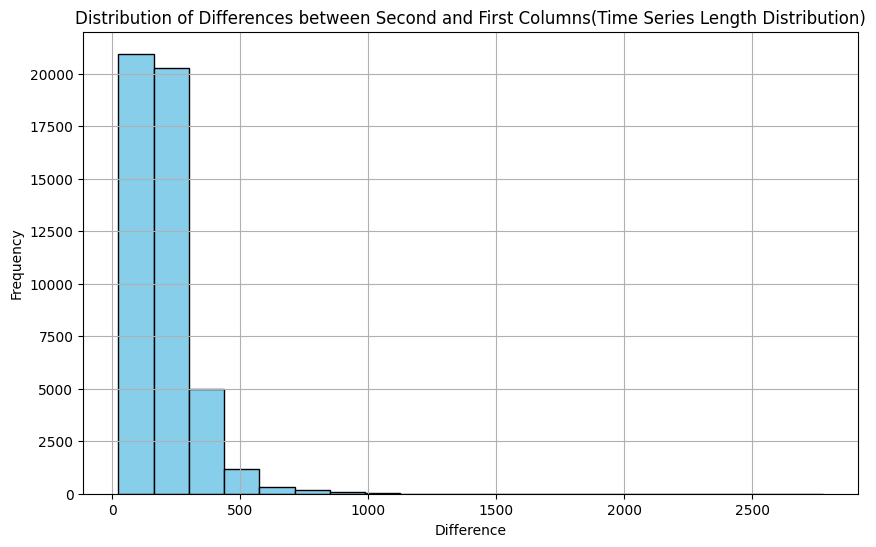

In [14]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_periods_df['difference'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences between Second and First Columns(Time Series Length Distribution)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
label_mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5
}
categories=np.vectorize(label_mapping.get)(categories_data)

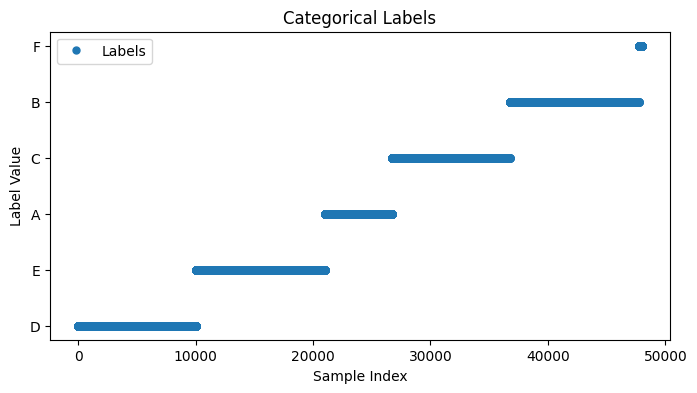

In [16]:
# Plot labels (assuming they are categorical)
plt.figure(figsize=(8, 4))
plt.plot(categories_data, marker='o', linestyle='None', markersize=5, label='Labels')
plt.title('Categorical Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label Value')
plt.legend()
plt.show()

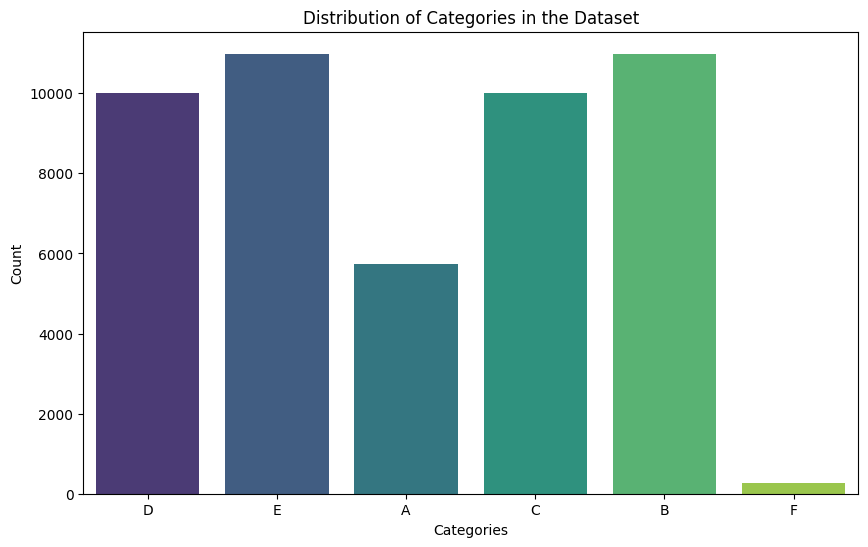

In [17]:

plt.figure(figsize=(10, 6))
sns.countplot(x=categories_data, palette='viridis')
plt.title('Distribution of Categories in the Dataset')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [18]:
# Compute class weights based on the original time series lengths
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(categories),
                                     y=categories)

# Create a dictionary mapping class indices to class weights
class_weights_dict = dict(zip(np.unique(categories), class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.3966480446927374, 1: 0.7281332483844544, 2: 0.7986423080762703, 3: 0.7987220447284346, 4: 0.7289293849658315, 5: 28.880866425992778}


**OriginalSeriesWithoutPadding**

In [19]:
df = pd.DataFrame(data=training_data)
df = df.astype(np.float32)
df['Start'] = valid_periods_data[:,0]
df['End'] = valid_periods_data[:,1]
df['Categories'] = categories
df['Difference']=valid_periods_df['difference']

In [20]:
df

,0,1,2,3,4,5,6,7,8,9,...,2770,2771,2772,2773,2774,2775,Start,End,Categories,Difference
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.744444,0.640741,0.516667,0.602778,0.367593,0.331481,2325,2776,3,451
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.740000,0.640000,0.536000,0.600000,0.460000,0.396000,2325,2776,3,451
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.901249,0.932531,0.955206,0.960481,0.946506,0.977140,2325,2776,3,451
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.430416,0.486370,0.450502,0.470588,0.569584,0.571019,2712,2776,3,64
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.681818,0.704545,0.863636,0.727273,0.818182,0.840909,2682,2776,3,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.240361,0.319784,0.447455,0.454175,0.623485,0.013329,2642,2776,5,134
47996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.617589,0.494914,0.504665,0.504545,0.521760,0.091133,2642,2776,5,134
47997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.565789,0.588816,0.625000,0.526316,0.582237,0.552632,2676,2776,5,100
47998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.492228,0.523316,0.445596,0.445596,0.585492,0.404145,2676,2776,5,100


In [21]:
category_groups = df.groupby('Categories')

# Create a dictionary to store DataFrames for each category
category_dataframes = {}

# Iterate over each category and create a DataFrame for it
for category, group_df in category_groups:
    category_dataframes[category] = group_df



In [22]:
category_dataframes

{0:          0    1    2    3    4    5    6    7    8    9  ...      2770  \
 20991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.704036   
 20992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.962211   
 20993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.894928   
 20994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.916492   
 20995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.745223   
 ...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
 26714  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.151937   
 26715  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.233419   
 26716  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.275043   
 26717  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.789641   
 26718  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.548077   
 
            2771      2772      2773      2774      2775  Start   End  \
 20991  0.594619  0.58

# **Splitting Data for Inspecting Data Sizes in Validation and Test Data**

In [23]:
# Control the fixed test and validation sizes for each category
test_size=0.15
validation_size=0.15

# Initialize dictionaries to store train, test, and validation sets for each category
train_sets = {}
test_sets = {}
validation_sets = {}

# Iterate over each category DataFrame
for category, category_df in category_dataframes.items():
    # Extract timestamps and data for each time series in each category
    starts, ends = category_df['Start'].values, category_df['End'].values
    time_series_data = category_df.drop(['Start', 'End', 'Categories'], axis=1).values

    # Split the data into train, test, and validation sets while preserving start and end times
    train_data, test_validation_data, train_start, test_validation_start, train_end, test_validation_end = train_test_split(
        time_series_data, starts, ends, test_size=(test_size + validation_size), random_state=42
    )

    # Further split test_validation_data into test and validation sets
    test_data, validation_data, test_start, validation_start, test_end, validation_end = train_test_split(
        test_validation_data, test_validation_start, test_validation_end, test_size=validation_size/(test_size + validation_size), random_state=42
    )

    # Store the sets in dictionaries
    train_sets[category] = {'data': train_data, 'start': train_start, 'end': train_end}
    test_sets[category] = {'data': test_data, 'start': test_start, 'end': test_end}
    validation_sets[category] = {'data': validation_data, 'start': validation_start, 'end': validation_end}



In [24]:
train_counts = {}
test_counts = {}
validation_counts = {}

# Iterate over each category DataFrame
for category, _ in category_dataframes.items():
    # Count the number of time series in each set
    train_count = len(train_sets[category]['data'])
    test_count = len(test_sets[category]['data'])
    validation_count = len(validation_sets[category]['data'])

    # Store the counts in dictionaries
    train_counts[category] = train_count
    test_counts[category] = test_count
    validation_counts[category] = validation_count

# Display the results
for category in train_counts:
    print(f"Category {category}:")
    print(f"  Number of Time Series in Train Set: {train_counts[category]}")
    print(f"  Number of Time Series in Test Set: {test_counts[category]}")
    print(f"  Number of Time Series in Validation Set: {validation_counts[category]}")
    print()

Category 0:
  Number of Time Series in Train Set: 4009
  Number of Time Series in Test Set: 859
  Number of Time Series in Validation Set: 860

Category 1:
  Number of Time Series in Train Set: 7690
  Number of Time Series in Test Set: 1648
  Number of Time Series in Validation Set: 1649

Category 2:
  Number of Time Series in Train Set: 7011
  Number of Time Series in Test Set: 1503
  Number of Time Series in Validation Set: 1503

Category 3:
  Number of Time Series in Train Set: 7011
  Number of Time Series in Test Set: 1502
  Number of Time Series in Validation Set: 1503

Category 4:
  Number of Time Series in Train Set: 7682
  Number of Time Series in Test Set: 1646
  Number of Time Series in Validation Set: 1647

Category 5:
  Number of Time Series in Train Set: 193
  Number of Time Series in Test Set: 42
  Number of Time Series in Validation Set: 42



# **Data Replicating for Sequences Shorter than Window Size**

In [25]:


window=200
unique_categories = np.unique(categories)

for k in unique_categories:

  category_data = train_sets[k]
  time_series_data = category_data['data']
  starts, ends = category_data['start'], category_data['end']

  for i in range(len(time_series_data)):

      difference = ends[i] - starts[i]

      if difference < 200:
          # Extract relevant_data from time_series_data
          relevant_data = time_series_data[i, starts[i]:ends[i]]

          # Calculate how many times the relevant_data should be replicated
          replication_factor = (window + 20) // difference + 1

          # Replicate relevant_data to exceed window size + 20
          replicated_data = np.tile(relevant_data, replication_factor)[:window + 20]

          # Update time_series_data with replicated_data
          time_series_data[i, starts[i] - (len(replicated_data) - len(relevant_data)):ends[i]] = replicated_data

          # Update starts based on the length of replicated_data
          starts[i] = starts[i] - (len(replicated_data) - len(relevant_data)-1)

  train_sets[k]['data']=time_series_data
  train_sets[k]['start']=starts



# **Zero Padding**

In [26]:
def build_sequences(row,window=200, telescope=9, stride=20):
    dataset=[]
    labels=[]
    assert window % stride == 0
    padding_check = len(row)%window

    if(padding_check != 0):
        padding_len = window - len(row)%window
        padding = np.zeros(padding_len, dtype='float32')
    else:
        padding = np.zeros(0)

    temp_row = np.concatenate((padding,row))
    assert len(temp_row) % window == 0

    for idx in np.arange(0, len(temp_row)-window-telescope, stride):
        dataset.append(temp_row[idx:idx+window])
        labels.append(temp_row[idx+window:idx+window+telescope])



    return dataset, labels



In [27]:
train_sets

{0: {'data': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.97951752e-01, 1.51811540e-01, 2.77000000e+02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.02035165e-01, 1.63350388e-01, 1.84000000e+02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.50957596e-01, 8.67336690e-01, 4.32000000e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.16841632e-01, 3.63858879e-01, 1.84000000e+02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.15413558e-01, 9.17293251e-01, 2.67000000e+02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          8.00000012e-01, 8.12903225e-01, 2.88000000e+02]]),
  'start': array([2499, 2557, 2344, ..., 2557, 2509, 2488]),
  'end': array([2776, 2776, 2776, ..., 2776, 2776, 2776])},
 1: {'data': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.30147052e-01, 9.19117630e-01, 2.88

# **DataFrame  - Dict and Vice Versa Conversions for Category Based Data**

In [28]:
window = 200
stride = 20
telescope = 18
autoregressive_tel = 18
X_train = {}
Y_train = {}
X_val = {}
Y_val = {}
X_test = {}
Y_test = {}
unique_categories = np.unique(categories)

for i in unique_categories:
    X_train[unique_categories[i]] = []
    Y_train[unique_categories[i]] = []
    X_val[unique_categories[i]] = []
    Y_val[unique_categories[i]] = []
    X_test[unique_categories[i]] = []
    Y_test[unique_categories[i]] = []

    df = train_sets[unique_categories[i]]['data']
    df_start = train_sets[unique_categories[i]]['start']
    df_end = train_sets[unique_categories[i]]['end']

    result_df = pd.concat([pd.DataFrame(df), pd.DataFrame(df_start), pd.DataFrame(df_end)], axis=1)

    dfv = validation_sets[unique_categories[i]]['data']
    df_startv = validation_sets[unique_categories[i]]['start']
    df_endv = validation_sets[unique_categories[i]]['end']

    result_dfv = pd.concat([pd.DataFrame(dfv), pd.DataFrame(df_startv), pd.DataFrame(df_endv)], axis=1)

    dft = test_sets[unique_categories[i]]['data']
    df_startt = test_sets[unique_categories[i]]['start']
    df_endt = test_sets[unique_categories[i]]['end']

    result_dft = pd.concat([pd.DataFrame(dft), pd.DataFrame(df_startt), pd.DataFrame(df_endt)], axis=1)

    for row in result_df.itertuples():
        start_index, end_index = row[-2], row[-1]
        row_data = row[int(start_index):int(end_index)]
        all_a, all_b = build_sequences(row_data, window=window, telescope=autoregressive_tel, stride=stride)
        X_train[unique_categories[i]].extend(all_a)
        Y_train[unique_categories[i]].extend(all_b)

    for row in result_dft.itertuples():
        start_index, end_index = row[-2], row[-1]
        row_data = row[int(start_index):int(end_index)]
        all_c, all_d = build_sequences(row_data, window=window, telescope=autoregressive_tel, stride=stride)
        X_test[unique_categories[i]].extend(all_c)
        Y_test[unique_categories[i]].extend(all_d)

    for row in result_dfv.itertuples():
        start_index, end_index = row[-2], row[-1]
        row_data = row[int(start_index):int(end_index)]
        all_e, all_f = build_sequences(row_data, window=window, telescope=autoregressive_tel, stride=stride)
        X_val[unique_categories[i]].extend(all_e)
        Y_val[unique_categories[i]].extend(all_f)

In [29]:
for i in unique_categories:
    X_train[i] = np.array(X_train[i])
    Y_train[i] = np.array(Y_train[i])
    X_val[i] = np.array(X_val[i])
    Y_val[i] = np.array(Y_val[i])
    X_test[i] = np.array(X_test[i])
    Y_test[i] = np.array(Y_test[i])
    print(X_train[i].shape,Y_train[i].shape,X_val[i].shape,Y_val[i].shape,X_test[i].shape,Y_test[i].shape)



(47730, 200) (47730, 18) (7860, 200) (7860, 18) (7990, 200) (7990, 18)
(79910, 200) (79910, 18) (6680, 200) (6680, 18) (6020, 200) (6020, 18)
(76170, 200) (76170, 18) (9360, 200) (9360, 18) (9960, 200) (9960, 18)
(77680, 200) (77680, 18) (9710, 200) (9710, 18) (10140, 200) (10140, 18)
(78800, 200) (78800, 18) (7140, 200) (7140, 18) (6580, 200) (6580, 18)
(2090, 200) (2090, 18) (190, 200) (190, 18) (150, 200) (150, 18)


In [30]:
for i in unique_categories:
    X_train[i] = np.expand_dims(X_train[i], axis=2)
    Y_train[i] = np.expand_dims(Y_train[i], axis=2)
    X_val[i] = np.expand_dims(X_val[i], axis=2)
    Y_val[i] = np.expand_dims(Y_val[i], axis=2)
    X_test[i] = np.expand_dims(X_test[i], axis=2)
    Y_test[i] = np.expand_dims(Y_test[i], axis=2)

    print(X_train[i].shape,Y_train[i].shape,X_val[i].shape,Y_val[i].shape,X_test[i].shape,Y_test[i].shape)

(47730, 200, 1) (47730, 18, 1) (7860, 200, 1) (7860, 18, 1) (7990, 200, 1) (7990, 18, 1)
(79910, 200, 1) (79910, 18, 1) (6680, 200, 1) (6680, 18, 1) (6020, 200, 1) (6020, 18, 1)
(76170, 200, 1) (76170, 18, 1) (9360, 200, 1) (9360, 18, 1) (9960, 200, 1) (9960, 18, 1)
(77680, 200, 1) (77680, 18, 1) (9710, 200, 1) (9710, 18, 1) (10140, 200, 1) (10140, 18, 1)
(78800, 200, 1) (78800, 18, 1) (7140, 200, 1) (7140, 18, 1) (6580, 200, 1) (6580, 18, 1)
(2090, 200, 1) (2090, 18, 1) (190, 200, 1) (190, 18, 1) (150, 200, 1) (150, 18, 1)


# Conv- BiLSTM Model

In [40]:
def build_CONV_LSTM_model(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    y = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(y)

    x = tfkl.Attention()([x,x])

    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    crop_size = output_layer.shape[1] - output_shape[0]
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [41]:
batch_size = 64
epochs = 100
models=[]
for i in range(len(unique_categories)):
    
    input_shape = X_train[i].shape[1:]
    output_shape = Y_train[i].shape[1:]
    
    
    
    models.append(build_CONV_LSTM_model(input_shape,output_shape))
    
    models[i].summary()
    



Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 128)             33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 conv (Conv1D)               (None, 200, 128)             49280     ['bidirectional_lstm[0][0]']  
                                                                                                  
 attention (Attention)       (None, 200, 128)             0         ['conv[0][0]',  

# Category Based Model Training

In [42]:
for i in range(len(unique_categories)):
    
    
    history = models[i].fit(
        x = X_train[i],
        y = Y_train[i],
        batch_size = batch_size,
        epochs = epochs,
        validation_data = (X_val[i], Y_val[i]),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
        ]
    ).history



Epoch 1/100
746/746 [==============================] - 31s 25ms/step - loss: 0.0436 - val_loss: 0.0205 - lr: 0.0010
Epoch 2/100
746/746 [==============================] - 17s 23ms/step - loss: 0.0198 - val_loss: 0.0130 - lr: 0.0010
Epoch 3/100
746/746 [==============================] - 17s 23ms/step - loss: 0.0185 - val_loss: 0.0116 - lr: 0.0010
Epoch 4/100
746/746 [==============================] - 17s 23ms/step - loss: 0.0178 - val_loss: 0.0113 - lr: 0.0010
Epoch 5/100
746/746 [==============================] - 17s 23ms/step - loss: 0.0178 - val_loss: 0.0113 - lr: 0.0010
Epoch 6/100
746/746 [==============================] - 17s 23ms/step - loss: 0.0174 - val_loss: 0.0114 - lr: 0.0010
Epoch 7/100
746/746 [==============================] - 17s 23ms/step - loss: 0.0170 - val_loss: 0.0127 - lr: 0.0010
Epoch 8/100
746/746 [==============================] - 17s 23ms/step - loss: 0.0169 - val_loss: 0.0108 - lr: 0.0010
Epoch 9/100
746/746 [==============================] - 17s 23ms/step - l

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1191/1191 [==============================] - 27s 22ms/step - loss: 0.0175 - val_loss: 0.0096 - lr: 1.0000e-05
Epoch 1/100
1214/1214 [==============================] - 33s 24ms/step - loss: 0.0443 - val_loss: 0.0144 - lr: 0.0010
Epoch 2/100
1214/1214 [==============================] - 27s 22ms/step - loss: 0.0234 - val_loss: 0.0134 - lr: 0.0010
Epoch 3/100
1214/1214 [==============================] - 27s 22ms/step - loss: 0.0216 - val_loss: 0.0131 - lr: 0.0010
Epoch 4/100
1214/1214 [==============================] - 27s 22ms/step - loss: 0.0206 - val_loss: 0.0146 - lr: 0.0010
Epoch 5/100
1214/1214 [==============================] - 27s 22ms/step - loss: 0.0196 - val_loss: 0.0134 - lr: 0.0010
Epoch 6/100
1214/1214 [==============================] - 27s 22ms/step - loss: 0.0191 - val_loss: 0.0128 - lr: 0.0010
Epoch 7/100
1214/1214 [==============================] - 27s 23ms/step - loss: 0.0193 - val_loss: 0.0125 - lr: 0.0010
Epoch 8/100
1214/1214 [==============================] - 27s 22m

In [44]:
for i in range(len(unique_categories)):
    models[i].save("TimeSerieEnsemble{}".format(i))

In [33]:
models=[]

time_series_models="/kaggle/input/timeserieensemblenew/TimeSerieEnsemble/"

for i in range(len(unique_categories)):
    models.append(tfk.models.load_model(time_series_models+"{}".format(i)))
    

# Keeping Pre-Trained Models Weights

In [37]:
for i in range(len(unique_categories)):
    models[i].trainable=False

In [41]:
input_shape = X_train[i].shape[1:]


In [46]:
for i in range(6):
    models[i]._name = 'model_{}'.format(i)

# Ensembling Category Based Trained Models with Attention Layer

In [62]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dense, Multiply
from tensorflow.keras.models import Model

def build_ensemble_model(models, input_shape):
    # Input layer for the ensemble
    input_layer = Input(shape=input_shape, name='ensemble_input')

    # Getting outputs from each pre-trained model
    model_outputs = [model(input_layer) for model in models]

    # Concatenating outputs
    concatenated = Concatenate(axis=-1)(model_outputs)

    # Attention Mechanism
    # Step 1: Learn a score for each model's output
    attention_probs = Dense(concatenated.shape[-1], activation='softmax', name='attention_probs')(concatenated)

    # Step 2: Multiply scores with outputs
    weighted_output = Multiply()([concatenated, attention_probs])

    # Step 3: Combining weighted outputs to match individual model output shape
    final_output = Dense(1, activation='linear', name='final_output')(weighted_output)

    # Build the model
    ensemble_model = Model(inputs=input_layer, outputs=final_output, name='ensemble_model')
    
    return ensemble_model

# Load your pre-trained models here
# models = [model1, model2, model3, model4, model5, model6]

ensemble_model = build_ensemble_model(models, input_shape)

# Compile the model (assuming prediction task)
ensemble_model.compile(optimizer='adam', loss='mean_squared_error')

# Now you can use ensemble_model.predict(...) for predictions


In [63]:
ensemble_model.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ensemble_input (InputLayer  [(None, 200, 1)]             0         []                            
 )                                                                                                
                                                                                                  
 model_0 (Functional)        (None, 18, 1)                83457     ['ensemble_input[0][0]']      
                                                                                                  
 model_1 (Functional)        (None, 18, 1)                83457     ['ensemble_input[0][0]']      
                                                                                                  
 model_2 (Functional)        (None, 18, 1)                83457     ['ensemble_input[

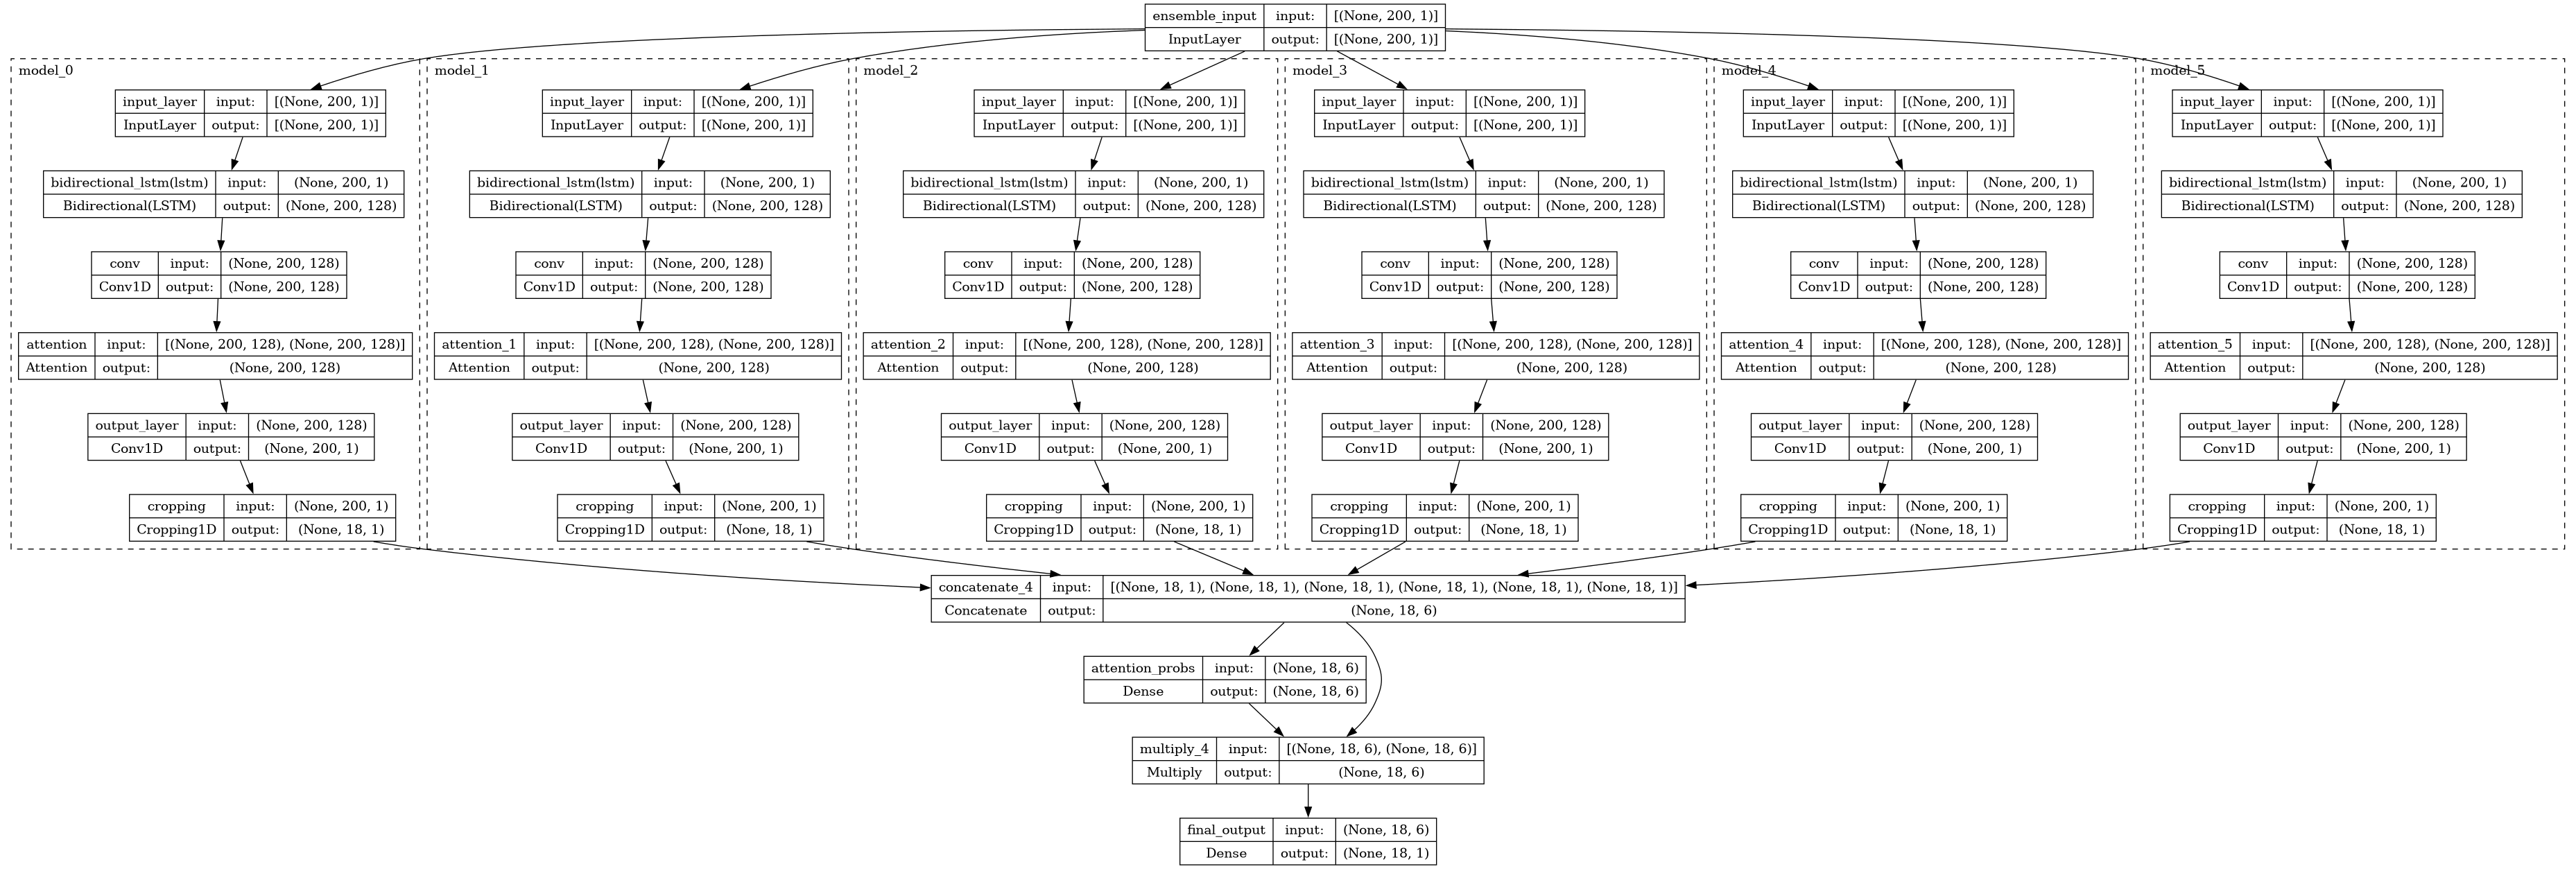

In [64]:
tfk.utils.plot_model(ensemble_model, expand_nested=True, show_shapes=True)

In [ ]:
X_train = np.concatenate(list(X_train.values()))
Y_train = np.concatenate(list(Y_train.values()))
X_val = np.concatenate(list(X_val.values()))
Y_val = np.concatenate(list(Y_val.values()))
X_test = np.concatenate(list(X_test.values()))
Y_test = np.concatenate(list(Y_test.values()))

print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape,X_test.shape,Y_test.shape)

# Unifying Category Based Data to Re-train Ensembled Model

In [66]:
print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape,X_test.shape,Y_test.shape)

(362380, 200, 1) (362380, 18, 1) (40940, 200, 1) (40940, 18, 1) (40840, 200, 1) (40840, 18, 1)


In [67]:
for i in range(6):
    models[i].summary()

Model: "model_0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 128)             33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 conv (Conv1D)               (None, 200, 128)             49280     ['bidirectional_lstm[0][0]']  
                                                                                                  
 attention (Attention)       (None, 200, 128)             0         ['conv[0][0]',          

In [ ]:
batch_size=128
epochs=100

history = ensemble_model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history



Epoch 1/100
2832/2832 [==============================] - 232s 76ms/step - loss: 0.0275 - val_loss: 0.0108 - lr: 0.0010
Epoch 2/100
2832/2832 [==============================] - 211s 74ms/step - loss: 0.0182 - val_loss: 0.0104 - lr: 0.0010
Epoch 3/100
2832/2832 [==============================] - 211s 75ms/step - loss: 0.0173 - val_loss: 0.0098 - lr: 0.0010
Epoch 4/100
2832/2832 [==============================] - 211s 75ms/step - loss: 0.0168 - val_loss: 0.0097 - lr: 0.0010
Epoch 5/100
2832/2832 [==============================] - 211s 74ms/step - loss: 0.0167 - val_loss: 0.0097 - lr: 0.0010
Epoch 6/100
2832/2832 [==============================] - 211s 74ms/step - loss: 0.0167 - val_loss: 0.0097 - lr: 0.0010
Epoch 7/100
2832/2832 [==============================] - 211s 74ms/step - loss: 0.0167 - val_loss: 0.0097 - lr: 0.0010
Epoch 8/100
2832/2832 [==============================] - 208s 74ms/step - loss: 0.0167 - val_loss: 0.0097 - lr: 0.0010
Epoch 9/100
2832/2832 [=========================